# Global Forecasting Models: Dependent multi-series forecasting (Multivariate forecasting)

[Univariate time series forecasting](../introduction-forecasting/introduction-forecasting.html) models a single time series as a linear or nonlinear combination of its lags, using past values of the series to predict its future. Global forecasting, involves building a single predictive model that considers all time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce. This approach is computationally efficient, easy to maintain, and can yield more robust generalizations across time series.

In **dependent multi-series forecasting (multivariate time series)**, all series are modeled together in a single model, considering that each time series depends not only on its past values but also on the past values of the other series. The forecaster is expected not only to learn the information of each series separately but also to relate them. An example is the measurements made by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

<p style="text-align: center">
<img src="../img/forecaster_multivariate_train_matrix_diagram.png" style="width: 600px">
<br>
<font size="2.5"> <i>Internal Forecaster time series transformation to train a forecaster with multiple dependent time series.</i></font>
</p>

Since as many training matrices are created as there are series in the dataset, it must be decided on which level the forecasting will be performed. To predict the next *n* steps a model is trained for each step to be predicted, the selected level in the figure is `Series 1`. This strategy is of the type [direct multi-step forecasting](../introduction-forecasting/introduction-forecasting.html#direct-multi-step-forecasting).

<p style="text-align: center">
<img src="../img/forecaster_multivariate_prediction_diagram.png" style="width: 600px">
<br>
<font size="2.5"> <i>Diagram of direct forecasting with multiple dependent time series.</i></font>
</p>


Using the <code>ForecasterDirectMultiVariate</code> class, it is possible to easily build machine learning models for dependent multi-series forecasting.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Why can only one series be predicted?

The key challenge with directly applying a strategy to multiple time series is scalability. Typically, each time series and each time step would require its own model. For instance, if you have 1,000 time series and a prediction horizon of 24 steps, you would need to train 24,000 separate models. This approach becomes impractical very quickly. That's why the <code>ForecasterDirectMultiVariate</code> can learn from multiple series but can only predict one at a time.

The good news? We are developing a new class that will enable predictions for multiple series simultaneously. Stay tuned!

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Skforecast offers additional approaches to create Global Forecasting Models:

<ul>
    <li>
    <a href="../user_guides/independent-multi-time-series-forecasting.html">Global Forecasting Models: Independent multi-series forecasting</a>
    </li>
    <li>
    <a href="../user_guides/multi-series-with-different-length-and-different_exog.html">Global Forecasting Models: Time series with different lengths and different exogenous variables</a>
    </li>
    <li>
    <a href="../user_guides/forecasting-with-deep-learning-rnn-lstm.html">Global Forecasting Models: Forecasting with Deep Learning</a>
    </li>
</ul>


To learn more about global forecasting models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py44-multi-series-forecasting-skforecast.html">Global Forecasting Models: Multi-series forecasting with Python and skforecast</a>
    </li>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py59-scalable-forecasting-model.html">Scalable Forecasting: modeling thousand time series with a single global model</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py53-global-forecasting-models">Global Forecasting Models: Comparative Analysis of Single and Multi-Series Forecasting Modeling</a>
    </li>
    <li>
    <a href="https://cienciadedatos.net/documentos/py54-forecasting-with-deep-learning">Forecasting with Deep Learning</a>
    </li>
</ul>

</div>

## Libraries and data

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.direct import ForecasterDirectMultiVariate
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries
from skforecast.model_selection import random_search_forecaster_multiseries
from skforecast.model_selection import bayesian_search_forecaster_multiseries

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name="air_quality_valencia_no_missing")

air_quality_valencia_no_missing
-------------------------------
Hourly measures of several air chemical pollutant at Valencia city (Avd.
Francia) from 2019-01-01 to 20213-12-31. Including the following variables:
pm2.5 (µg/m³), CO (mg/m³), NO (µg/m³), NO2 (µg/m³), PM10 (µg/m³), NOx (µg/m³),
O3 (µg/m³), Veloc. (m/s), Direc. (degrees), SO2 (µg/m³). Missing values have
been imputed using linear interpolation.
Red de Vigilancia y Control de la Contaminación Atmosférica, 46250047-València -
Av. França, https://mediambient.gva.es/es/web/calidad-ambiental/datos-
historicos.
Shape of the dataset: (43824, 10)


In [3]:
# Aggregate at daily frequency to reduce dimensions
# ==============================================================================
data = data.resample('D').mean()
print("Shape: ", data.shape)
data.head()

Shape:  (1826, 10)


,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01,6.000000,0.141667,17.375000,37.250000,21.458333,63.458333,20.291667,0.416667,207.416667,17.208333
2019-01-02,6.041667,0.170833,23.458333,49.333333,26.416667,85.041667,11.708333,0.579167,225.375000,17.375000
2019-01-03,5.916667,0.216667,41.291667,53.250000,36.166667,116.333333,9.833333,0.500000,211.833333,21.625000
2019-01-04,5.458333,0.204167,21.208333,45.750000,32.208333,77.958333,15.166667,0.675000,199.583333,22.166667
2019-01-05,4.541667,0.191667,10.291667,36.375000,32.875000,51.833333,21.083333,0.875000,254.208333,24.916667


In [4]:
data

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01,6.000000,0.141667,17.375000,37.250000,21.458333,63.458333,20.291667,0.416667,207.416667,17.208333
2019-01-02,6.041667,0.170833,23.458333,49.333333,26.416667,85.041667,11.708333,0.579167,225.375000,17.375000
2019-01-03,5.916667,0.216667,41.291667,53.250000,36.166667,116.333333,9.833333,0.500000,211.833333,21.625000
2019-01-04,5.458333,0.204167,21.208333,45.750000,32.208333,77.958333,15.166667,0.675000,199.583333,22.166667
2019-01-05,4.541667,0.191667,10.291667,36.375000,32.875000,51.833333,21.083333,0.875000,254.208333,24.916667
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,3.250000,0.100000,28.250000,58.041667,28.083333,101.291667,14.666667,0.445833,208.958333,18.416667
2023-12-28,3.166667,0.100000,38.708333,56.416667,35.666667,115.666667,15.375000,0.250000,168.208333,22.291667
2023-12-29,3.000000,0.100000,29.979167,55.666667,51.354167,101.458333,8.958333,0.237500,231.458333,37.250000


In [5]:
# Split data into train-val-test
# ==============================================================================
end_train = '2023-05-31 23:59:59'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  "
    f"(n={len(data_test)})"
)

Train dates : 2019-01-01 00:00:00 --- 2023-05-31 00:00:00  (n=1612)
Test dates  : 2023-06-01 00:00:00 --- 2023-12-31 00:00:00  (n=214)


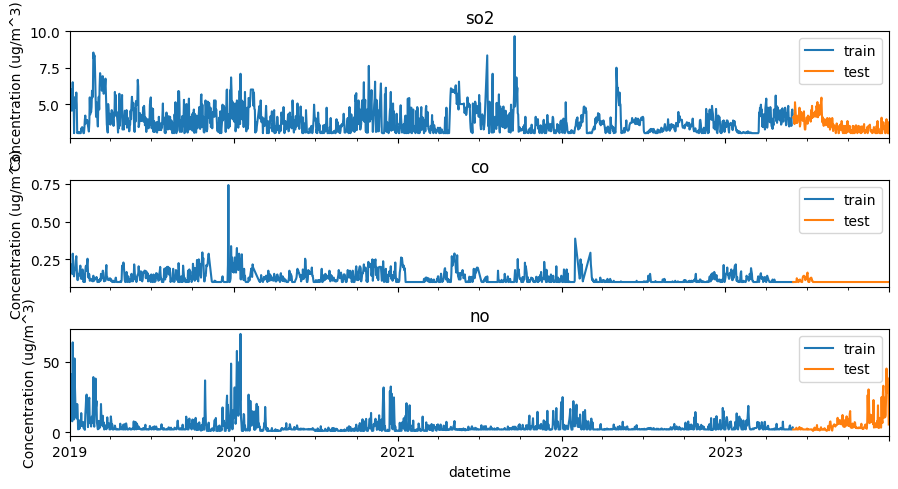

In [6]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

for i, col in enumerate(data.columns[:3]):
    data_train[col].plot(ax=axes[i], label='train')
    data_test[col].plot(ax=axes[i], label='test')
    axes[i].set_ylabel('Concentration (ug/m^3)')
    axes[i].set_title(col)
    axes[i].legend(loc='upper right')

fig.tight_layout()
plt.show();

## Train and predict ForecasterDirectMultiVariate

When initializing the forecaster, the series (`level`) to be predicted and the maximum number of `steps` must be indicated since a different model will be created for each step.

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

<code>ForecasterDirectMultiVariate</code> includes the <code>n_jobs</code> parameter, allowing multi-process parallelization. This allows to train regressors for all steps simultaneously.

The benefits of parallelization depend on several factors, including the regressor used, the number of fits to be performed, and the volume of data involved. When the <code>n_jobs</code> parameter is set to <code>'auto'</code>, the level of parallelization is automatically selected based on heuristic rules that aim to choose the best option for each scenario.

For a more detailed look at parallelization, visit <a href="../faq/parallelization-skforecast.html">Parallelization in skforecast</a>.

</div>

In [7]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'co',
                 steps           = 7,
                 lags            = 7,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[7]),
                 n_jobs          = 'auto'
             )

forecaster.fit(series=data_train)
forecaster

============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: LGBMRegressor 
Target series (level): co 
Lags: [1 2 3 4 5 6 7] 
Window features: ['roll_mean_7'] 
Window size: 7 
Maximum steps to predict: 7 
Multivariate series: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Exogenous included: False 
Exogenous names: None 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2023-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-11 12:11:12 
Last fit date: 2024-11-11 12:11:15 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [8]:
# Predict with forecaster MultiVariate
# ==============================================================================
predictions = forecaster.predict(steps=None)  # All steps
predictions

,co
2023-06-01,0.100046
2023-06-02,0.106861
2023-06-03,0.109452
2023-06-04,0.106873
2023-06-05,0.095040
2023-06-06,0.108114
2023-06-07,0.104563


In [9]:
# Predict only a subset of steps
# ==============================================================================
predictions = forecaster.predict(steps=[1, 5])
predictions

,co
2023-06-01,0.100046
2023-06-05,0.095040


In [10]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(random_state=9871)
predictions

,co,co_lower_bound,co_upper_bound
2023-06-01,0.100046,0.089832,0.111817
2023-06-02,0.106861,0.093617,0.116840
2023-06-03,0.109452,0.098173,0.124021
2023-06-04,0.106873,0.092592,0.122083
2023-06-05,0.095040,0.085764,0.107368
2023-06-06,0.108114,0.094295,0.118989
2023-06-07,0.104563,0.092779,0.117915


## Backtesting MultiVariate

See the [backtesting user guide](../user_guides/backtesting.html) to learn more about backtesting.

In [11]:
# Backtesting MultiVariate
# ==============================================================================
cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster    = forecaster,
                                           series        = data,
                                           cv            = cv,
                                           metric        = 'mean_absolute_error',
                                           n_jobs        = 'auto',
                                           verbose       = False,
                                           show_progress = True
                                       )
print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/31 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,co,0.017541



Backtest predictions


,co
2023-06-01,0.100046
2023-06-02,0.106861
2023-06-03,0.109452
2023-06-04,0.106873


## Hyperparameter tuning and lags selection MultiVariate

The `grid_search_forecaster_multiseries`, `random_search_forecaster_multiseries` and `bayesian_search_forecaster_multiseries` functions in the `model_selection` module allow for lags and hyperparameter optimization. It is performed using the backtesting strategy for validation as in other Forecasters, [see the user guide here](../user_guides/hyperparameter-tuning-and-lags-selection.html).

The following example shows how to use `random_search_forecaster_multiseries` to find the best lags and model hyperparameters.

In [12]:
# Create and forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 steps              = 7,
                 lags               = 7,
                 window_features    = RollingFeatures(stats=['mean'], window_sizes=[7]),
                 transformer_series = StandardScaler()
             )

In [13]:
# Random search MultiVariate
# ==============================================================================
lags_grid = [7, 14]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=3, stop=6, step=1, dtype=int)
}

cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

results = random_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              cv                  = cv,
              metric              = 'mean_absolute_error',
              aggregate_metric    = 'weighted_average',
              n_iter              = 5,
              return_best         = False,
              n_jobs              = 'auto',
              verbose             = False,
              show_progress       = True
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,lags_label,params,mean_absolute_error,n_estimators,max_depth
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 19, 'max_depth': 5}",0.016567,19,5
1,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'max_depth': 5}",0.017329,16,5
2,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 18, 'max_depth': 3}",0.017705,18,3
3,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 19, 'max_depth': 5}",0.017724,19,5
4,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 18, 'max_depth': 3}",0.017854,18,3
5,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 17, 'max_depth': 3}",0.017885,17,3
6,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 16, 'max_depth': 5}",0.017923,16,5
7,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 15, 'max_depth': 3}",0.018076,15,3
8,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 17, 'max_depth': 3}",0.018101,17,3
9,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'max_depth': 3}",0.018235,15,3


It is also possible to perform a bayesian optimization with `optuna` using the `bayesian_search_forecaster_multiseries` function. For more information about this type of optimization, see the [user guide here](../user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search).

In [14]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 level           = 'co',
                 steps           = 7,
                 lags            = 7,
                 window_features = RollingFeatures(stats=['mean'], window_sizes=[7])
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

cv = TimeSeriesFold(
         steps                 = 7,
         initial_train_size    = len(data_train),
         refit                 = False,
         allow_incomplete_fold = True
     )

results, best_trial = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = data,
                          exog                  = None, 
                          search_space          = search_space,
                          cv                    = cv,
                          metric                = 'mean_absolute_error',
                          aggregate_metric      = 'weighted_average',
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )

results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,n_estimators,min_samples_leaf,max_features
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'min_samples_leaf': 9, 'm...",0.018025,16,9,log2
1,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 14, 'min_samples_leaf': 8, 'm...",0.019328,14,8,log2
2,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'min_samples_leaf': 4, 'm...",0.020233,15,4,sqrt
3,[co],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 12, 'min_samples_leaf': 6, 'm...",0.020452,12,6,log2


`best_trial` contains information of the trial which achived the best results. See more in [Study class](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study).

In [15]:
# Optuna best trial in the study
# ==============================================================================
best_trial

FrozenTrial(number=3, state=1, values=[0.018024662716443113], datetime_start=datetime.datetime(2024, 11, 11, 12, 11, 27, 31959), datetime_complete=datetime.datetime(2024, 11, 11, 12, 11, 28, 127266), params={'lags': 14, 'n_estimators': 16, 'min_samples_leaf': 9, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lags': CategoricalDistribution(choices=(7, 14)), 'n_estimators': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('log2', 'sqrt'))}, trial_id=3, value=None)

## Different lags for each time series

If a `dict` is passed to the `lags` argument, it allows setting different lags for each of the series. The keys of the dictionary must be the names of the series to be used during training.

In [16]:
data

,so2,co,no,no2,pm10,nox,o3,veloc.,direc.,pm2.5
datetime,,,,,,,,,,
2019-01-01,6.000000,0.141667,17.375000,37.250000,21.458333,63.458333,20.291667,0.416667,207.416667,17.208333
2019-01-02,6.041667,0.170833,23.458333,49.333333,26.416667,85.041667,11.708333,0.579167,225.375000,17.375000
2019-01-03,5.916667,0.216667,41.291667,53.250000,36.166667,116.333333,9.833333,0.500000,211.833333,21.625000
2019-01-04,5.458333,0.204167,21.208333,45.750000,32.208333,77.958333,15.166667,0.675000,199.583333,22.166667
2019-01-05,4.541667,0.191667,10.291667,36.375000,32.875000,51.833333,21.083333,0.875000,254.208333,24.916667
...,...,...,...,...,...,...,...,...,...,...
2023-12-27,3.250000,0.100000,28.250000,58.041667,28.083333,101.291667,14.666667,0.445833,208.958333,18.416667
2023-12-28,3.166667,0.100000,38.708333,56.416667,35.666667,115.666667,15.375000,0.250000,168.208333,22.291667
2023-12-29,3.000000,0.100000,29.979167,55.666667,51.354167,101.458333,8.958333,0.237500,231.458333,37.250000


In [17]:
data.columns

Index(['so2', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.',
       'pm2.5'],
      dtype='object')

In [18]:
# Create and fit forecaster MultiVariate Custom lags
# ==============================================================================
lags_dict = {
    'so2': [7, 14], 'co': 7, 'no': [7, 14], 'no2': [7, 14],
    'pm10': [7, 14], 'nox': [7, 14], 'o3': [7, 14], 'veloc.': 3,
    'direc.': 3, 'pm2.5': [7, 14]
}
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 steps              = 7,
                 lags               = lags_dict,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
display(predictions)

,co
2023-06-01,0.098798
2023-06-02,0.107185
2023-06-03,0.112225
2023-06-04,0.107208
2023-06-05,0.098643
2023-06-06,0.100375
2023-06-07,0.099513


If a `None` is passed to any of the keys of the `lags` argument, that series will not be used to create the `X` training matrix.

In this example, no lags are created for the `'co'` series, but since it is the `level` of the forecaster, the `'co'` column will be used to create the `y` training matrix.

In [19]:
# Create and fit forecaster MultiVariate Custom lags with None
# ==============================================================================
lags_dict = {
    'so2': [7, 14], 'co': None, 'no': [7, 14], 'no2': [7, 14],
    'pm10': [7, 14], 'nox': [7, 14], 'o3': [7, 14], 'veloc.': 3,
    'direc.': 3, 'pm2.5': [7, 14]
}
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = lags_dict,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
display(predictions)

,co
2023-06-01,0.107966
2023-06-02,0.118692
2023-06-03,0.125480
2023-06-04,0.132908
2023-06-05,0.118237
2023-06-06,0.121638
2023-06-07,0.120753


It is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific lags that have been created.

In [20]:
# Extract training matrix
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_train_step_1, y_train_step_1 = forecaster.filter_train_X_y_for_step(
                                     step    = 1,
                                     X_train = X_train,
                                     y_train = y_train,
                                 )

X_train_step_1.head(4)

,so2_lag_7,so2_lag_14,no_lag_7,no_lag_14,no2_lag_7,no2_lag_14,pm10_lag_7,pm10_lag_14,nox_lag_7,nox_lag_14,o3_lag_7,o3_lag_14,veloc._lag_1,veloc._lag_2,veloc._lag_3,direc._lag_1,direc._lag_2,direc._lag_3,pm2.5_lag_7,pm2.5_lag_14
datetime,,,,,,,,,,,,,,,,,,,,
2019-01-15,1.061795,2.362414,3.462136,2.232968,2.971237,2.098158,1.175259,0.229121,3.419881,2.298657,-1.871669,-1.800847,-0.726869,-0.979544,-0.792953,0.673274,1.019948,1.581166,2.104497,1.084751
2019-01-16,1.805006,2.408865,6.247303,3.270300,2.622404,3.254290,1.156585,0.599485,4.605306,3.486375,-1.754371,-2.256761,-1.150585,-0.726869,-0.979544,0.171311,0.673274,1.019948,1.782163,1.108193
2019-01-17,-0.982034,2.269513,0.826174,6.311248,2.596491,3.629037,-0.119456,1.327762,1.927209,5.208336,-0.331300,-2.356354,-0.944558,-1.150585,-0.726869,0.511174,0.171311,0.673274,-0.374541,1.705975
2019-01-18,1.479852,1.758556,8.194077,2.886629,4.617729,2.911437,1.221944,1.032094,6.726230,3.096583,-1.433461,-2.073068,-1.115600,-0.944558,-1.150585,1.436094,0.511174,0.171311,0.815163,1.782163


In [21]:
# Extract training matrix
# ==============================================================================
y_train_step_1.head(4)

datetime
2019-01-15    3.149604
2019-01-16    1.554001
2019-01-17   -0.323179
2019-01-18   -0.417038
Freq: D, Name: co_step_1, dtype: float64

## Exogenous variables in MultiVariate

Exogenous variables are predictors that are independent of the model being used for forecasting, and their future values must be known in order to include them in the prediction process.

In the <code>ForecasterDirectMultiVariate</code>, as in the other forecasters, exogenous variables can be easily included as predictors using the `exog` argument.

To learn more about exogenous variables in skforecast visit the [exogenous variables user guide](../user_guides/exogenous-variables.html).

## Scikit-learn transformers in MultiVariate

By default, the <code>ForecasterDirectMultiVariate</code> class uses the scikit-learn `StandardScaler` transformer to scale the data. This transformer is applied to all series. However, it is possible to use different transformers for each series or not to apply any transformation at all:

+ If `transformer_series` is a `transformer` the same transformation will be applied to all series. 

+ If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them (check warning message).

Learn more about [using scikit-learn transformers](../user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

In [22]:
# Transformers in MultiVariate
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = {'co': StandardScaler(), 'no2': StandardScaler()},
                 transformer_exog   = None,
                 weight_func        = None,
             )

forecaster.fit(series=data_train)
forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\skforecast\utils\utils.py:363: IgnoredArgumentWarning: {'o3', 'direc.', 'nox', 'no', 'pm10', 'so2', 'pm2.5', 'veloc.'} not present in `transformer_series`. No transformation is applied to these series. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


============================ 
ForecasterDirectMultiVariate 
============================ 
Regressor: LGBMRegressor 
Target series (level): co 
Lags: [1 2 3 4 5 6 7] 
Window features: None 
Window size: 7 
Maximum steps to predict: 7 
Multivariate series: so2, co, no, no2, pm10, nox, o3, veloc., direc., pm2.5 
Exogenous included: False 
Exogenous names: None 
Transformer for series: 'co': StandardScaler(), 'no2': StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2023-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-11 12:11:30 
Last fit date: 2024-11-11 12:11:32 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

## Weights in MultiVariate

The weights are used to control the influence that each observation has on the training of the model.

Learn more about [weighted time series forecasting](../user_guides/weighted-time-series-forecasting.html) with skforecast.

In [23]:
# Weights in MultiVariate
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights


forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = custom_weights
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=7).head(3)

,co
2023-06-01,0.106243
2023-06-02,0.103617
2023-06-03,0.102537


<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

The <code>weight_func</code> argument will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`.

In [24]:
# Source code weight function
# ==============================================================================
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Compare multiple metrics

All four functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`,  `random_search_forecaster_multiseries`, and `bayesian_search_forecaster_multiseries`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list can include custom metrics, and the best model is selected based on the first metric in the list and the first aggregation method (if more than one is provided).

In [25]:
# Grid search MultiVariate with multiple metrics
# ==============================================================================
forecaster = ForecasterDirectMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 level              = 'co',
                 lags               = 7,
                 steps              = 7
             )    

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

cv = TimeSeriesFold(
         steps              = 7,
         initial_train_size = len(data_train),
         refit              = False,
     )

lags_grid = [7, 14]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster       = forecaster,
              series           = data,
              exog             = None,
              lags_grid        = lags_grid,
              param_grid       = param_grid,
              cv               = cv,
              metric           = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              aggregate_metric = 'weighted_average',
              return_best      = True,
              n_jobs           = 'auto',
              verbose          = False,
              show_progress    = True
          )

results

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.014486558378954958
  Levels: ['co']



,levels,lags,lags_label,params,mean_absolute_error,custom_metric,mean_squared_error,alpha
0,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.01},0.014487,0.021981,0.000439,0.01
1,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},0.014487,0.021981,0.000439,0.10
2,[co],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 1},0.014487,0.021981,0.000439,1.00
3,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.01},0.014773,0.022789,0.000511,0.01
4,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.1},0.014773,0.022789,0.000511,0.10
5,[co],"[1, 2, 3, 4, 5, 6, 7]","[1, 2, 3, 4, 5, 6, 7]",{'alpha': 1},0.014773,0.022789,0.000511,1.00


## Feature importances

Since <code>ForecasterDirectMultiVariate</code> fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [26]:
# Feature importances for step 1
# ==============================================================================
forecaster.get_feature_importances(step=1)

,feature,importance
14,co_lag_1,146
31,no_lag_4,84
61,pm10_lag_6,64
1,so2_lag_2,52
0,so2_lag_1,50
...,...,...
47,no2_lag_6,8
131,pm2.5_lag_6,8
132,pm2.5_lag_7,7
82,nox_lag_13,5


## Training and prediction matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process. Check the [How to Extract Training and Prediction Matrices](../user_guides/training-and-prediction-matrices.html) user guide for more information.